In [10]:
import os, sys
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.linalg import svd
import scipy.stats as stats
import concurrent.futures

### Loading Data

In [11]:
# Load data configuration
data_dir = r'C:\Users\alail\OneDrive\Documentos\dado_iniciais'
# data_dir = r'D:\Pre-Processing Data'
pen = [75]

columns_name = [
    'File ID',
    'Fault type',
    'Fault resistance', 
    'Incidence angle',
    'Fault location',
    'Fault distance',
]
df_cases = pd.read_csv(
    os.path.join(data_dir, 'cenarios_falta_preprocessamento.csv'),
    header=None,
    index_col=False,
    names=columns_name
)

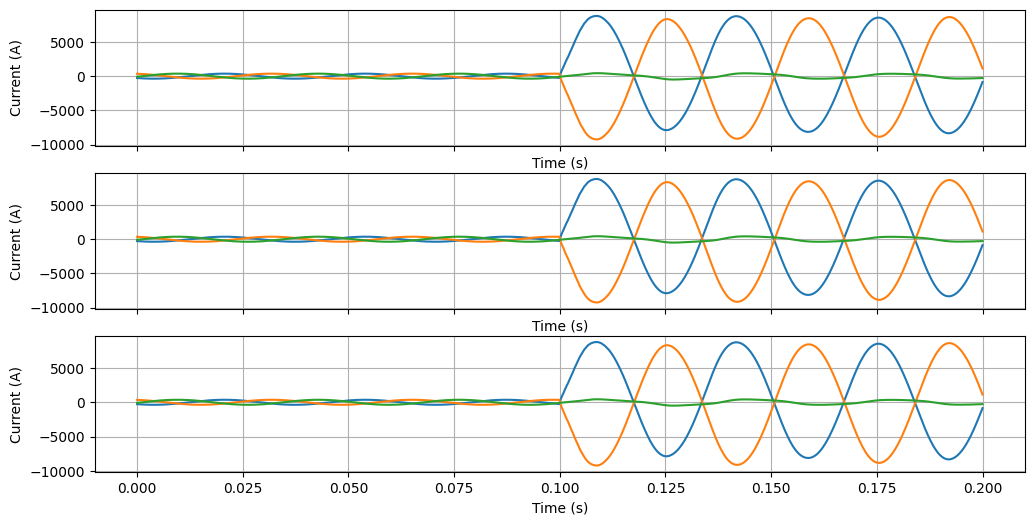

In [12]:
x = np.loadtxt(r'C:\Users\alail\OneDrive\Documentos\dado_iniciais\pen75\sinal_320_.csv',delimiter=',')
x *= 1000
time = np.linspace(0, 3072/15360, 3072)

fig, axs = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
for i in range(3):
    axs[i].plot(time, x[:,3])
    axs[i].plot(time, x[:,4])
    axs[i].plot(time, x[:,5])
    axs[i].grid()
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Current (A)')
plt.savefig('signal.svg', format='svg', dpi=1200, bbox_inches='tight')

In [13]:
# Load data
if os.path.exists(os.path.join(data_dir, 'data.npy')) and False:
    data = np.load(os.path.join(data_dir, 'data.npy'))
else:
    one_data_size = (6, 3072)
    print(len(df_cases))
    data = np.zeros((len(pen) * len(df_cases), *one_data_size))
    for i, p in tqdm(enumerate(pen), total=len(pen)):
        n = 0
        for j, case in df_cases.iterrows():
            data[i * len(df_cases) + n] = np.loadtxt(
                os.path.join(data_dir, f'pen{p}', f'sinal_{j+1}_.csv'),
                delimiter=','
            ).T
            n += 1
    np.save(os.path.join(data_dir, 'data.npy'), data) # save in numpy for faster loading

1350


  0%|          | 0/1 [00:00<?, ?it/s]

File ID             1613.0
Fault type             9.0
Fault resistance      10.0
Incidence angle       45.1
Fault location         1.0
Fault distance         0.0
Name: 52, dtype: float64


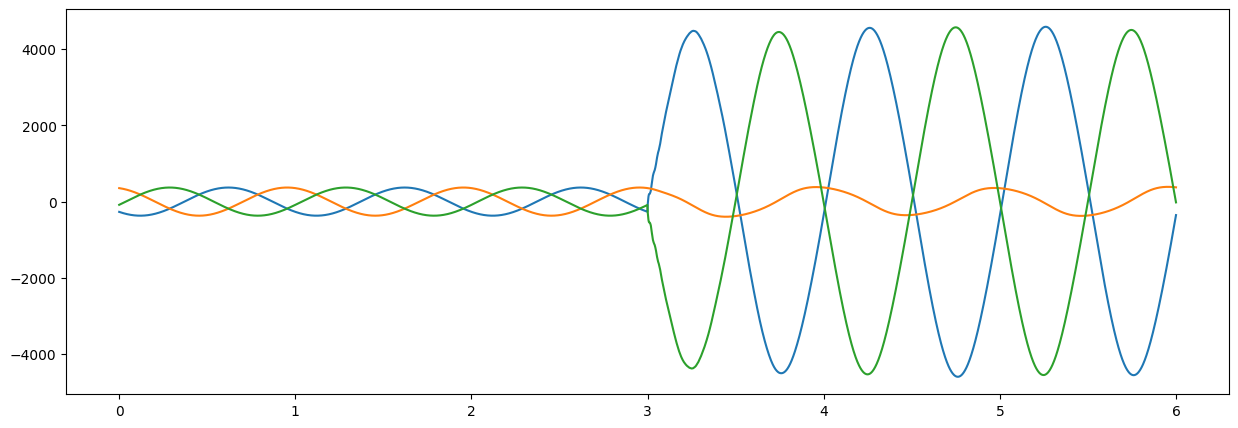

In [14]:
num = 52
dat = data[num]*1000
print(df_cases.loc[num])
plt.figure(figsize=(15, 5))
fs = 512
time = np.linspace(0, dat.shape[1]/fs, dat.shape[1])
plt.plot(time, dat[3,:])
plt.plot(time, dat[4,:])
plt.plot(time, dat[5,:])

In [15]:
# Create a Dataframe to store the features
columns_name = [
    'File ID',
    'Fault type',
    'Fault resistance', 
    'Incidence angle',
    'Fault location',
    'Fault distance',
    'Pen',
]
columns_type = {
    'File ID': int,
    'Fault type': int,
    'Fault resistance': float,
    'Incidence angle': float,
    'Fault location': int,
    'Fault distance': float,
    'Pen': int
}
df_features = pd.DataFrame(
    columns= columns_name,
    index=range(len(pen) * len(df_cases))
    
)
for i, p in enumerate(pen):
    n = 0
    for j, case in df_cases.iterrows():
        df_features.loc[i * len(df_cases) + n] = case.tolist() + [p]
        n += 1
df_features = df_features.astype(columns_type)
del df_cases

In [16]:
def get_metrics(data:np.ndarray, prefix:str='')->dict:
    '''
    parameters
    ----------
    data : np.ndarray
        data to be processed

    returns
    -------
    Energy : float
        Energy of the signal
    Entropy : float
        Entropy of the signal
    RMS Amplitude : float
        RMS amplitude of the signal
    Kurtose : float
        Kurtosis of the signal
    Skewness : float
        Skewness of the signal
    Singular Value Decomposition (SVD) : np.ndarray
        Singular Value Decomposition of the signal
    Mean : float
        Mean of the signal
    Median : float
        Median of the signal
    Standard Deviation : float
        Standard deviation of the signal
    Coefficient of Variation : float
        Coefficient of variation of the signal
    Minimum Value : float
        Minimum value of the signal
    Maximum Value : float
        Maximum value of the signal
    Variance : float
        Variance of the signal
    '''
    res_dict = {
        f'{prefix} Energy': np.sum(data**2, axis=-1),
        f'{prefix} Entropy': stats.entropy(np.abs(data), axis=-1),
        f'{prefix} RMS Amplitude': np.sqrt(np.mean(data**2, axis=-1)),
        f'{prefix} Kurtosis': stats.kurtosis(data, axis=-1),
        f'{prefix} Skewness': stats.skew(data, axis=-1),
        f'{prefix} SVD': np.apply_along_axis(lambda x: svd(x[None, :])[1][0], -1, data),
        f'{prefix} Mean': np.mean(data, axis=-1),
        f'{prefix} Median': np.median(data, axis=-1),
        f'{prefix} Standard Deviation': np.std(data, axis=-1),
        f'{prefix} Coefficient of Variation': np.std(data, axis=-1) / np.mean(data, axis=-1),
        f'{prefix} Minimum Value': np.min(data, axis=-1),
        f'{prefix} Maximum Value': np.max(data, axis=-1),
        f'{prefix} Variance': np.var(data, axis=-1),
    }
    return res_dict


In [17]:
fs = 512*60
smp_per_cycle = 512

fault_idx = data.shape[-1]//2
start_cycle1 = fault_idx - smp_per_cycle
start_cycle2 = fault_idx - smp_per_cycle//2
start_cycle3 = fault_idx
names_prefix = ['Pre-', 'Fault-', 'Pos-']
names_phase = ['Va', 'Vb', 'Vc', 'Ia', 'Ib', 'Ic']

In [18]:
## Fourier Transform
df_fourier = df_features.copy()
metrics_all = []
for i in tqdm(range(data.shape[0])):
    fft_pre = np.abs(np.fft.fft(data[i,:,start_cycle1:start_cycle1+512], axis=-1))/smp_per_cycle
    fft_fault = np.abs(np.fft.fft(data[i,:,start_cycle2:start_cycle2+512], axis=-1))/smp_per_cycle
    fft_pos = np.abs(np.fft.fft(data[i,:,start_cycle3:start_cycle3+512], axis=-1))/smp_per_cycle
    metrics = {}
    for j in range(6):
        metrics.update(get_metrics(fft_pre[j],   prefix=f'{names_prefix[0]}{names_phase[j]} - '))
        metrics.update(get_metrics(fft_fault[j], prefix=f'{names_prefix[1]}{names_phase[j]} - '))
        metrics.update(get_metrics(fft_pos[j],   prefix=f'{names_prefix[2]}{names_phase[j]} - '))
    metrics_all.append(metrics)
df_fourier = df_fourier.join(pd.DataFrame(metrics_all))
df_fourier.to_csv(
    rf'new_features/fourier_features.csv', 
    index=True)

  0%|          | 0/1350 [00:00<?, ?it/s]

### Wavelet Features

In [19]:
import pywt
df_wavelet = df_features.copy()

max_level = pywt.dwt_max_level(data[0,0,start_cycle1:start_cycle1+512].shape[-1], pywt.Wavelet('db4'))
all_metrics = []
for i in tqdm(range(data.shape[0])):
    metrics = {}
    for j in range(6):
        coeffs = [
            pywt.wavedec(data[i,j,start_cycle1:start_cycle1+512], 'db4', level=max_level),
            pywt.wavedec(data[i,j,start_cycle2:start_cycle2+512], 'db4', level=max_level),
            pywt.wavedec(data[i,j,start_cycle3:start_cycle3+512], 'db4', level=max_level)
        ]
        for k in range(0, max_level+1):
            metrics.update(get_metrics(coeffs[0][k], prefix=f'Level {k}: {names_prefix[0]}{names_phase[j]} -'))
            metrics.update(get_metrics(coeffs[1][k], prefix=f'Level {k}: {names_prefix[1]}{names_phase[j]} -'))
            metrics.update(get_metrics(coeffs[2][k], prefix=f'Level {k}: {names_prefix[2]}{names_phase[j]} -'))      
    all_metrics.append(metrics)
df_wavelet = df_wavelet.join(pd.DataFrame(all_metrics))


df_wavelet.to_csv(
    rf'new_features/wavelet_features.csv', 
    index=True)

  0%|          | 0/1350 [00:00<?, ?it/s]

### Stockwell Features

In [20]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(r'new_features.ipynb'))))
from functions.TS.ST import stockwell_transform

df_stockwell = df_features.copy()

all_metrics = []
for i in tqdm(range(data.shape[0])):
    metrics = {}
    for j in range(6):
        matrixs = [
            np.abs(stockwell_transform(data[i,j,start_cycle1:start_cycle1+512], 0.05)),
            np.abs(stockwell_transform(data[i,j,start_cycle2:start_cycle2+512], 0.05)),
            np.abs(stockwell_transform(data[i,j,start_cycle3:start_cycle3+512], 0.05))
        ]
        MAF = [
            np.max(matrixs[0], axis=0),
            np.max(matrixs[1], axis=0),
            np.max(matrixs[2], axis=0)
        ]
        MAT = [
            np.max(matrixs[0].T, axis=0),
            np.max(matrixs[1].T, axis=0),
            np.max(matrixs[2].T, axis=0)
        ]
        metrics.update(get_metrics(MAF[0], prefix=f'MAF: {names_prefix[0]}{names_phase[j]} -'))
        metrics.update(get_metrics(MAF[1], prefix=f'MAF: {names_prefix[1]}{names_phase[j]} -'))
        metrics.update(get_metrics(MAF[2], prefix=f'MAF: {names_prefix[2]}{names_phase[j]} -'))
        metrics.update(get_metrics(MAT[0], prefix=f'MAT: {names_prefix[0]}{names_phase[j]} -'))
        metrics.update(get_metrics(MAT[1], prefix=f'MAT: {names_prefix[1]}{names_phase[j]} -'))
        metrics.update(get_metrics(MAT[2], prefix=f'MAT: {names_prefix[2]}{names_phase[j]} -'))
    all_metrics.append(metrics)
    # if i == 5:
    #     break
df_stockwell = df_stockwell.join(pd.DataFrame(all_metrics))
df_stockwell.to_csv(
    rf'new_features/stockwell_features.csv', 
    index=True)

  0%|          | 0/1350 [00:00<?, ?it/s]

C:\Users\alail\AppData\Local\Temp\ipykernel_35036\2432670227.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f'{prefix} Kurtosis': stats.kurtosis(data, axis=-1),
C:\Users\alail\AppData\Local\Temp\ipykernel_35036\2432670227.py:42: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f'{prefix} Skewness': stats.skew(data, axis=-1),


### Three-Phase Features

In [21]:
## Three-Phase Transform
df_threePhase = df_features.copy()

from functions.TT import clarke as clk
from functions.TT import componentes_simetricas as cs

sym_maxtix = (1/3)*np.array([
    [1, 1, 1],
    [1, np.exp(2j*np.pi/3), np.exp(-2j*np.pi/3)],
    [1, np.exp(-2j*np.pi/3), np.exp(2j*np.pi/3)],
])
clark_matrix = np.array([
    [1/3, 1/3, 1/3], 
    [2/3, -1/3, -1/3], 
    [0, (3**0.5)/3, -(3**0.5)/3]
])

metrics_all = []
for i in tqdm(range(data.shape[0])):
    slides = np.lib.stride_tricks.sliding_window_view(data[i,:,start_cycle1:start_cycle3+512], window_shape=smp_per_cycle, axis=-1)
    fft = np.fft.fft(slides, axis=-1)
    fft = fft/smp_per_cycle

    # Symetrical Components
    v012 = np.abs(np.dot(sym_maxtix, fft[0:3,:,1]))
    i012 = np.abs(np.dot(sym_maxtix, fft[3:6,:,1]))
    # Parks Transform
    v_clark = np.abs(np.dot(clark_matrix, fft[0:3,:,1]))
    i_clark = np.abs(np.dot(clark_matrix, fft[3:6,:,1]))

    sym_names = ['0', '1', '2']
    clark_names = ['Alpha', 'Beta', 'Zero']

    metrics = {}
    for j in range(3):
        metrics.update(get_metrics(v012[j], prefix=f'Sym: V{sym_names[j]} - '))
        metrics.update(get_metrics(i012[j], prefix=f'Sym: I{sym_names[j]} - '))
        metrics.update(get_metrics(v_clark[j], prefix=f'Clark: V_{clark_names[j]} - '))
        metrics.update(get_metrics(i_clark[j], prefix=f'Clark: I_{clark_names[j]} - '))
    metrics_all.append(metrics)
    # break

df_threePhase = df_threePhase.join(pd.DataFrame(metrics_all))
df_threePhase.to_csv(
    rf'new_features/threePhase_features.csv', 
    index=True)

  0%|          | 0/1350 [00:00<?, ?it/s]

### EMD Features

In [11]:
import emd
df_emd = df_features.copy()
all_metrics = []
for i in tqdm(range(data.shape[0])):
    metrics = {}
    for j in range(6):
        imfs_pre = emd.sift.ensemble_sift(data[i,j,start_cycle1:start_cycle1+512], max_imfs=5).T
        imfs_fault = emd.sift.ensemble_sift(data[i,j,start_cycle2:start_cycle2+512], max_imfs=5).T
        imfs_pos = emd.sift.ensemble_sift(data[i,j,start_cycle3:start_cycle3+512], max_imfs=5).T

        if imfs_pre.shape[0] < 5:
            imfs_pre = np.pad(imfs_pre, ((0, 5-imfs_pre.shape[0]), (0, 0)), mode='constant')
        if imfs_fault.shape[0] < 5:
            imfs_fault = np.pad(imfs_fault, ((0, 5-imfs_fault.shape[0]), (0, 0)), mode='constant')
        if imfs_pos.shape[0] < 5:
            imfs_pos = np.pad(imfs_pos, ((0, 5-imfs_pos.shape[0]), (0, 0)), mode='constant')
            
        
        for k in range(imfs_pre.shape[0]):
            metrics.update(get_metrics(imfs_pre[k], prefix=f'IMF {k}: {names_prefix[0]}{names_phase[j]} -'))
            metrics.update(get_metrics(imfs_fault[k], prefix=f'IMF {k}: {names_prefix[1]}{names_phase[j]} -'))
            metrics.update(get_metrics(imfs_pos[k], prefix=f'IMF {k}: {names_prefix[2]}{names_phase[j]} -'))
    all_metrics.append(metrics)
    # if i == 1:
    #     break
df_emd = df_emd.join(pd.DataFrame(all_metrics))
df_emd.to_csv(
    rf'new_features/emd_features.csv', 
    index=True)

  0%|          | 0/1350 [00:00<?, ?it/s]

C:\Users\alail\AppData\Local\Temp\ipykernel_35036\2432670227.py:47: RuntimeWarning: invalid value encountered in scalar divide
  f'{prefix} Coefficient of Variation': np.std(data, axis=-1) / np.mean(data, axis=-1),


### VMD Features

In [12]:
from Metricas_VMD import apply_vmd
df_vmd = df_features.copy()
all_metrics = []
for i in tqdm(range(data.shape[0])):
    metrics = {}
    for j in range(6):
        imfs_pre = np.abs(apply_vmd(data[i,j,start_cycle1:start_cycle1+512]).T)
        imfs_fault = np.abs(apply_vmd(data[i,j,start_cycle2:start_cycle2+512]).T)
        imfs_pos = np.abs(apply_vmd(data[i,j,start_cycle3:start_cycle3+512]).T)
        for k in range(imfs_pre.shape[0]):
            metrics.update(get_metrics(imfs_pre[k], prefix=f'IMF {k}: {names_prefix[0]}{names_phase[j]} -'))
            metrics.update(get_metrics(imfs_fault[k], prefix=f'IMF {k}: {names_prefix[1]}{names_phase[j]} -'))
            metrics.update(get_metrics(imfs_pos[k], prefix=f'IMF {k}: {names_prefix[2]}{names_phase[j]} -'))
    all_metrics.append(metrics)
    # if i == 1:
    #     break
df_vmd = df_vmd.join(pd.DataFrame(all_metrics))
df_vmd.to_csv(
    rf'new_features/vmd_features.csv', 
    index=True)

  0%|          | 0/5400 [00:00<?, ?it/s]